In [15]:
import pandas as pd
import os
import shutil

def get_result(file_name):
    with open(file_name, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if line.startswith("individual's fitness value"):
                obj_val = float(line.split(": ")[1])
            if line.startswith("CPU time"):
                time = float(line.split(": ")[1])
            if line.startswith("individual's dissat value"):
                dissat = float(line.split(": ")[1])
            if line.startswith("individual's emission value"):
                emission = float(line.split(": ")[1])
    return obj_val, time, dissat, emission

In [2]:
n_station_list = [60, 90, 120, 200, 300, 400, 500]

final_result = dict()

for n_station in n_station_list:

    trk_list = [1,2] if n_station >= 60 else [1]
    rpm_list = [1,2] if n_station >= 60 else [1]

    for inst in range(1,2):
        for trk in trk_list:
            for rpm in rpm_list:
                obj_val_list = []
                time_list = []
                file_indices = []
                for i in range(1, 101):
                    file_name = f"Solutions/large/3h/{n_station}/{n_station}_{inst}_t{trk}_r{rpm}_{i}.txt"
                    if not os.path.exists(file_name):
                        continue
                    obj_val, time = get_result(file_name)
                    obj_val_list.append(obj_val)
                    time_list.append(time)
                    file_indices.append(i)
                df = pd.DataFrame({"obj_val": obj_val_list, "time": time_list, "index": file_indices})
                df = df.sort_values(by="obj_val")
                best_obj_val = df["obj_val"].head(20).mean()
                best_obj_best = df["obj_val"].head(20).min()
                best_time = df["time"].head(20).mean()
                best_std = df["obj_val"].head(20).std()
                final_result[f"{n_station}_{inst}_{trk}_{rpm}"] = {"best_obj_val": best_obj_val, "best_obj_best": best_obj_best,
                "best_time": best_time, "best_std": best_std}
                
                # Track the indices of the top 20 results
                top_20_indices = df["index"].head(20).tolist()
                
                # Preserve and renumber the top 20 files
                for new_index, old_index in enumerate(top_20_indices, start=1):
                    old_file_name = f"Solutions/large/3h/{n_station}/{n_station}_{inst}_t{trk}_r{rpm}_{old_index}.txt"
                    new_file_name = f"Solutions/large/3h/{n_station}/{n_station}_{inst}_t{trk}_r{rpm}_{new_index}.txt"
                    if old_file_name != new_file_name: 
                        shutil.copyfile(old_file_name, new_file_name)
                
                # Remove other files
                for i in range(1, 101):
                    if i > 20:
                        file_name = f"Solutions/large/3h/{n_station}/{n_station}_{inst}_t{trk}_r{rpm}_{i}.txt"
                        if os.path.exists(file_name):
                            os.remove(file_name)

                # Rename the top 20 files to 1, 2, 3, ..., 20


df = pd.DataFrame(final_result).T
df.index = df.index.astype(str)
split_index = df.index.str.split("_", expand=True)
split_index_df = pd.DataFrame(split_index.tolist(), index=df.index, columns=["n_station", "inst", "trk", "rpm"])

df[["n_station", "inst", "trk", "rpm"]] = split_index_df

df = df[["n_station", "inst", "trk", "rpm", "best_obj_val", "best_obj_best", "best_time", "best_std"]]

df.set_index(["n_station", "inst", "trk", "rpm"], inplace=True)

df = df.round(2)

df

best_obj_val  best_obj_best  best_time  best_std
n_station inst trk rpm                                                  
60        1    1   1         1031.72        1025.11       8.68      3.21
                   2          984.35         966.86      12.05      7.44
               2   1          944.78         918.45      11.46      7.78
                   2          905.04         896.28      13.03      5.15
90        1    1   1         3905.07        3865.03      10.71     17.24
                   2         3781.92        3735.60      14.12     19.15
               2   1         3707.17        3652.58      14.04     21.23
                   2         3608.64        3563.30      19.14     22.35
120       1    1   1         4205.12        4180.03       8.77     10.70
                   2         4108.32        4087.78      18.30      9.57
               2   1         4027.26        4007.56      14.08     11.70
                   2         3956.90        3909.70      17.10     15.59
200       1    1   1         7695.87        7636.22      14.54     22.64
                   2         7576.42        7539.85      25.16     14.91
               2   1         7473.85        7406.93      20.49     33.88
                   2         7398.57        7333.03      27.86     28.95
300       1    1   1        11027.51       10973.30      19.05     23.91
                   2        10901.78       10858.60      37.56     17.86
               2   1        10831.40       10756.00      25.91     24.65
                   2        10699.11       10638.50      44.37     24.60
400       1    1   1        14142.08       14090.00      22.39     21.12
                   2        14009.83       13974.40      44.62     15.84
               2   1        13971.24       13926.70      32.93     20.40
                   2        13853.31       13822.50      58.83     14.53
500       1    1   1        18823.05       18716.10      21.78     36.57
                   2        18598.11       18539.40      56.75     27.57
               2   1        18575.65       18493.30      34.88     40.59
                   2        18408.42       18250.20      60.70     45.66

In [1]:
import pandas as pd
import os

def get_result(file_name):
    with open(file_name, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if line.startswith("individual's fitness value"):
                obj_val = float(line.split(": ")[1])
            if line.startswith("CPU time"):
                time = float(line.split(": ")[1])
    return obj_val, time


# n_station_list = [15, 30, 60, 120, 200]

# trk_list = [1,2,3]
# rpm_list = [1,2,3]

final_result = dict()

# get the information from results files, for each combination of n_station, trk, rpm, there are 100 runs of the algorithm, so the filename is f"{n_station}_1_t{trk}_r{rpm}_{i}.txt" where i is from 1 to 100. We want to get the average, best, and std of the best 20 results from the 100 runs for each combination of n_station, trk, rpm, and put it in a dataframe. All the txt files are stored under the folder "Solutions/2024-08-03". Note that by best 20 we meant the 20 results with the smallest objective values, not the 20 results with the smallest CPU time. 
# for n_station in n_station_list:
    # for trk in trk_list:
        # for rpm in rpm_list:
for inst in range(300, 400):
    obj_val_list = []
    time_list = []
    for i in range(1, 101):
        file_name = f"Solutions/2024-08-20/15_{inst}_t1_r1_{i}.txt"
        if not os.path.exists(file_name):
            continue
        obj_val, time = get_result(file_name)
        obj_val_list.append(obj_val)
        time_list.append(time)
    df = pd.DataFrame({"obj_val": obj_val_list, "time": time_list})
    df = df.sort_values(by="obj_val")
    best_obj_val = df["obj_val"].head(20).mean()
    best_obj_best = df["obj_val"].head(20).min()
    best_time = df["time"].head(20).mean()
    best_std = df["obj_val"].head(20).std()
    final_result[f"15_{inst}_t1_r1"] = {"best_obj_val": best_obj_val, "best_obj_best": best_obj_best,
    "best_time": best_time, "best_std": best_std}
    # print(f"n_station: {n_station}, trk: {trk}, rpm: {rpm}, best_obj_val: {best_obj_val}, best_time: {best_time}, best_std: {best_std}")

df = pd.DataFrame(final_result).T
# split the index into n_station, trk, rpm
# Ensure the index is a string
df.index = df.index.astype(str)
split_index = df.index.str.split("_", expand=True)
# Split the index into three parts
split_index_df = pd.DataFrame(split_index.tolist(), index=df.index, columns=["n_station", "instance", "trk", "rpm"])

df[["n_station", "instance", "trk", "rpm"]] = split_index_df

df = df[["n_station", "instance", "trk", "rpm", "best_obj_val", "best_obj_best", "best_time", "best_std"]]

df.set_index(["n_station", "instance", "trk", "rpm"], inplace=True)

df = df.round(2)

df.to_csv("heuristic-15-upd-2.csv")

In [9]:
import pandas as pd
import os
import json

n_station = 6

heuristic = pd.read_csv(f"heuristic-6.csv")[["instance", "best_obj_val"]].to_dict(orient="records")
heuristic = {item["instance"]: item["best_obj_val"] for item in heuristic}
gaps = []
for i in range(2, 101):
    # open "6/6_{i}_0.5_wr_t1_r1/6_{i}_0.5_wr_t1_r1_xx_xx_xx.json"
    for root, dirs, files in os.walk(f"6/6_{i}_0.5_wr_t1_r1/"):
        for file in files:
            if file.endswith(".json"):
                with open(os.path.join(root, file), 'r') as f:
                    data = json.load(f)
                    obj_val = round(data["objective_value"],2)
                    gaps.append((i, (heuristic[i] - obj_val) / heuristic[i] * 100))
gaps = sorted(gaps, key=lambda x: x[1])
gaps

[(70, -0.9336445481827315),
 (45, -0.35250987027636776),
 (65, -0.3230365435089776),
 (25, -0.18005851901867723),
 (83, -0.035561877667142174),
 (4, 0.0),
 (9, 0.0),
 (17, 0.0),
 (23, 0.0),
 (26, 0.0),
 (27, 0.0),
 (33, 0.0),
 (41, 0.0),
 (43, 0.0),
 (79, 0.0),
 (80, 0.0),
 (84, 0.0),
 (92, 0.0),
 (73, 0.02236135957065745),
 (40, 0.031347962382452264),
 (16, 0.033003300330038156),
 (44, 0.041045286632919877),
 (97, 0.05012531328320992),
 (89, 0.050864699898260486),
 (54, 0.060834651417443916),
 (91, 0.06762468300929696),
 (19, 0.07739393512980035),
 (47, 0.07827022796203728),
 (37, 0.08143832612917086),
 (100, 0.08500690681117659),
 (34, 0.1252269738901866),
 (7, 0.1291155584247907),
 (38, 0.1452608643021481),
 (88, 0.16390755613834032),
 (35, 0.2034525277435167),
 (55, 0.2205801257306748),
 (3, 0.22566718995290813),
 (90, 0.234820530023483),
 (21, 0.26637069922309553),
 (71, 0.30799064621001565),
 (87, 0.3166138976837156),
 (69, 0.33983008495752465),
 (95, 0.3706823925863502),
 (68, 0

[2281.25, 2266.18, 2281.25, 2284.81, 2319.84, 2335.96, 2373.64, 2419.19, 2455.19, 2500.56, 2535.75, 2626.26, 2666.53, 2726.1, 2794.67, 2853.07, 2958.78, 3044.75, 3096.76, 3173.47, 3226.23]
[1139.41, 1132.14, 1139.51, 1141.63, 1158.92, 1167.36, 1185.96, 1208.81, 1226.73, 1249.59, 1267.04, 1312.16, 1332.54, 1362.42, 1396.43, 1425.67, 1478.81, 1521.51, 1547.65, 1585.86, 1612.5]
[40.5377, 31.6049, 37.3849, 25.9861, 33.3635, 20.5167, 28.5121, 25.9337, 28.9124, 22.9735, 27.615, 32.2206, 24.1234, 21.0016, 30.0531, 28.7771, 19.3495, 28.8686, 24.3085, 29.0637, 20.5309]


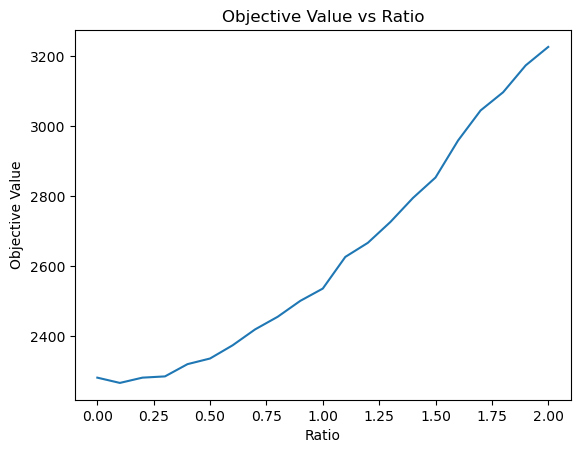

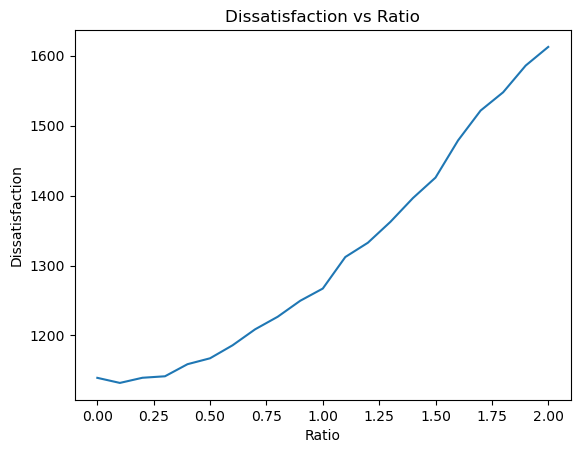

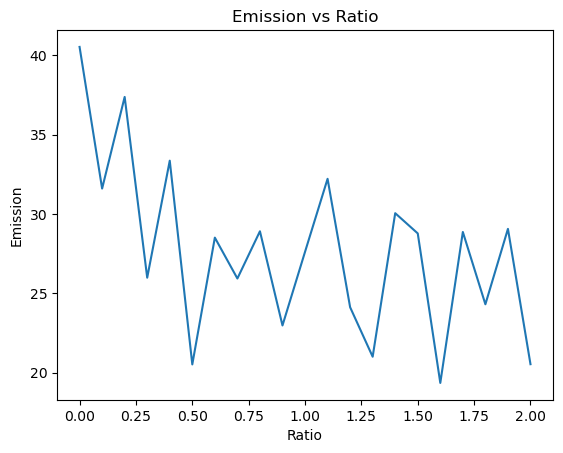

In [25]:
from matplotlib import pyplot as plt


n_station = 120
inst_no = 1

dissats = []
emissions = []
obj_vals = []
ratio_rng = [i/10.0 for i in range(21)]
for ratio in ratio_rng:
    obj_val, time, dissat, emission = get_result(f"Solutions/2024-09-12/{n_station}_{inst_no}_t1_r1_p{ratio}00000_1.txt")
    dissats.append(dissat)
    emissions.append(emission)
    obj_vals.append(obj_val)

print(obj_vals)
print(dissats)
print(emissions)

plt.plot(ratio_rng, obj_vals)
plt.xlabel("Ratio")
plt.ylabel("Objective Value")
plt.title("Objective Value vs Ratio")
plt.show()

plt.plot(ratio_rng, dissats)
plt.xlabel("Ratio")
plt.ylabel("Dissatisfaction")
plt.title("Dissatisfaction vs Ratio")
plt.show()

plt.plot(ratio_rng, emissions)
plt.xlabel("Ratio")
plt.ylabel("Emission")
plt.title("Emission vs Ratio")
plt.show()



In [8]:
10/100.0

0.1